In [1]:
!pip install prophet dagshub scikit-learn pandas numpy mlflow==2.2.2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import mlflow
import mlflow.pytorch
import dagshub
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("🚀 GPU Configuration:")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Current GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    device = torch.device('cuda')
    # Optimize for A100
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
else:
    print("⚠️ CUDA not available, using CPU")
    device = torch.device('cpu')

print(f"Using device: {device}")
print("All libraries imported successfully")

🚀 GPU Configuration:
CUDA available: True
GPU device: NVIDIA A100-SXM4-40GB
GPU memory: 39.6 GB
Current GPU memory allocated: 0.00 GB
Using device: cuda
All libraries imported successfully


In [4]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'nipkha21'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '202fb8a4c58a90b0eb3598b1037498eb6fe9f593'

dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow')

print("MLflow setup completed")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=c2f9a779-908b-4a31-899d-68ef8a99ed32&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c800f0c909c2c527cc328fec8889ee0f354a49274e02bb6019cae786e5976032




Accessing as nipkha21

Initialized MLflow to track repo "TomC333/ml-walmart-recruiting"

Repository TomC333/ml-walmart-recruiting initialized!

MLflow setup completed


In [5]:
model_name = "NBEATS_Sales_Forecasting"
print(f"Loading N-BEATS model from MLflow...")

# Get the latest version
try:
    latest_version = mlflow.get_latest_versions(model_name, stages=["None"])[0]
    run_id = latest_version.run_id
    print(f"Found model version {latest_version.version} from run: {run_id}")
except Exception as e:
    print(f"Error getting latest version: {e}")
    # If you know the specific run_id from your experiment, use it here
    run_id = "e0cfa07aa8b94ee795f3b2913f0b0798"  # Replace with actual run_id
    print(f"Using specific run_id: {run_id}")

# Load configurations
try:
    preprocessing_config = mlflow.artifacts.load_dict(f"runs:/{run_id}/preprocessing_config.json")
    print("✅ Loaded preprocessing config")
except Exception as e:
    print(f"Could not load preprocessing config: {e}")
    # Set default config based on experiment
    preprocessing_config = {
        "min_data_points": 30,
        "backcast_size": 20,
        "forecast_size": 10,
        "batch_size": 32,
        "remove_negative_sales": True,
        "holiday_dates": {
            "superbowl": ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
            "laborday": ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
            "thanksgiving": ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
            "christmas": ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
        },
        "external_cols": ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
        "lag_features": [1, 2, 3, 4, 52],
        "external_lags": [1, 2, 4, 8, 12],
        "nbeats_params": {
            "stack_types": ['trend', 'seasonality'],
            "nb_blocks_per_stack": 3,
            "thetas_dim": [2, 3],  # Reduced complexity
            "nb_harmonics": 5
        }
    }

try:
    feature_config = mlflow.artifacts.load_dict(f"runs:/{run_id}/feature_config.json")
    print(f"✅ Loaded feature config: {feature_config['best_phase']}")
    best_features = feature_config['features']
except Exception as e:
    print(f"Could not load feature config: {e}")
    # Set default to basic features
    best_features = []
    print("Using basic N-BEATS configuration (no additional features)")

print(f"Configuration loaded:")
print(f"  Best features: {len(best_features)} features")
print(f"  Backcast size: {preprocessing_config['backcast_size']}")
print(f"  Forecast size: {preprocessing_config['forecast_size']}")

Loading N-BEATS model from MLflow...
Error getting latest version: module 'mlflow' has no attribute 'get_latest_versions'
Using specific run_id: e0cfa07aa8b94ee795f3b2913f0b0798
✅ Loaded preprocessing config
✅ Loaded feature config: Phase4_NBEATS_External
Configuration loaded:
  Best features: 13 features
  Backcast size: 20
  Forecast size: 10


In [6]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, layer_size)] +
                                   [nn.Linear(layer_size, layer_size) for _ in range(layers-1)] +
                                   [nn.Linear(layer_size, theta_size)])
        self.basis_function = basis_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        theta = self.layers[-1](x)
        backcast, forecast = self.basis_function(theta)
        return backcast, forecast

class GenericBasis(nn.Module):
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, -self.forecast_size:]
        return backcast, forecast

class TrendBasis(nn.Module):
    def __init__(self, degree_of_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.polynomial_size = degree_of_polynomial + 1
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :self.polynomial_size]
        forecast = theta[:, self.polynomial_size:2*self.polynomial_size]

        # Create polynomial basis - fix device and dimension issues
        device = theta.device
        batch_size = theta.size(0)

        backcast_time = torch.arange(self.backcast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1) / self.backcast_size
        forecast_time = torch.arange(self.forecast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1) / self.forecast_size

        # Create basis matrices
        backcast_basis = torch.stack([backcast_time.pow(i) for i in range(self.polynomial_size)], dim=-1)  # [batch, backcast_size, polynomial_size]
        forecast_basis = torch.stack([forecast_time.pow(i) for i in range(self.polynomial_size)], dim=-1)  # [batch, forecast_size, polynomial_size]

        # Apply basis functions
        backcast_output = torch.sum(backcast.unsqueeze(1) * backcast_basis, dim=-1)  # [batch, backcast_size]
        forecast_output = torch.sum(forecast.unsqueeze(1) * forecast_basis, dim=-1)  # [batch, forecast_size]

        return backcast_output, forecast_output

class SeasonalityBasis(nn.Module):
    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :2*self.harmonics]
        forecast = theta[:, 2*self.harmonics:4*self.harmonics]

        # Create seasonal basis - fix device and dimension issues
        device = theta.device
        batch_size = theta.size(0)

        backcast_time = torch.arange(self.backcast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1)
        forecast_time = torch.arange(self.forecast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1)

        backcast_basis_list = []
        forecast_basis_list = []

        for i in range(self.harmonics):
            backcast_basis_list.append(torch.cos(2 * np.pi * (i+1) * backcast_time / self.backcast_size))
            backcast_basis_list.append(torch.sin(2 * np.pi * (i+1) * backcast_time / self.backcast_size))
            forecast_basis_list.append(torch.cos(2 * np.pi * (i+1) * forecast_time / self.forecast_size))
            forecast_basis_list.append(torch.sin(2 * np.pi * (i+1) * forecast_time / self.forecast_size))

        backcast_basis = torch.stack(backcast_basis_list, dim=-1)  # [batch, backcast_size, 2*harmonics]
        forecast_basis = torch.stack(forecast_basis_list, dim=-1)  # [batch, forecast_size, 2*harmonics]

        # Apply basis functions
        backcast_output = torch.sum(backcast.unsqueeze(1) * backcast_basis, dim=-1)  # [batch, backcast_size]
        forecast_output = torch.sum(forecast.unsqueeze(1) * forecast_basis, dim=-1)  # [batch, forecast_size]

        return backcast_output, forecast_output

class NBeats(nn.Module):
    def __init__(self, backcast_size, forecast_size, stack_types=['trend', 'seasonality'],
                 nb_blocks_per_stack=3, thetas_dim=[4, 8], nb_harmonics=None, share_weights_in_stack=False):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack

        self.stacks = nn.ModuleList()

        for stack_id, stack_type in enumerate(stack_types):
            if stack_type == 'trend':
                basis_function = TrendBasis(degree_of_polynomial=thetas_dim[stack_id],
                                          backcast_size=backcast_size, forecast_size=forecast_size)
                theta_size = 2 * (thetas_dim[stack_id] + 1)
            elif stack_type == 'seasonality':
                harmonics = nb_harmonics or min(forecast_size//2, 10)  # Limit harmonics to prevent issues
                basis_function = SeasonalityBasis(harmonics=harmonics,
                                                backcast_size=backcast_size, forecast_size=forecast_size)
                theta_size = 4 * harmonics
            else:  # generic
                basis_function = GenericBasis(backcast_size=backcast_size, forecast_size=forecast_size)
                theta_size = backcast_size + forecast_size

            stack = nn.ModuleList()
            for _ in range(nb_blocks_per_stack):
                block = NBeatsBlock(input_size=backcast_size, theta_size=theta_size,
                                  basis_function=basis_function, layers=4, layer_size=512)
                stack.append(block)
            self.stacks.append(stack)

    def forward(self, x):
        residuals = x
        forecast = torch.zeros(x.size(0), self.forecast_size, device=x.device)  # Fix device issue

        for stack in self.stacks:
            for block in stack:
                backcast, block_forecast = block(residuals)
                residuals = residuals - backcast
                forecast = forecast + block_forecast

        return forecast

print("✅ N-BEATS architecture defined")

✅ N-BEATS architecture defined


In [7]:
try:
    loaded_model = mlflow.pytorch.load_model(f"models:/{model_name}/latest")
    print("✅ Successfully loaded N-BEATS model from MLflow Model Registry")
except Exception as e:
    print(f"Error loading from registry: {e}")
    try:
        # Try loading from specific run
        loaded_model = mlflow.pytorch.load_model(f"runs:/{run_id}/nbeats_model")
        print("✅ Successfully loaded N-BEATS model from run artifacts")
    except Exception as e2:
        print(f"Error loading from run: {e2}")
        print("❌ Could not load model. Please check run_id and model name.")
        loaded_model = None

if loaded_model:
    loaded_model.eval()  # Set to evaluation mode
    print(f"Model loaded successfully with {sum(p.numel() for p in loaded_model.parameters())} parameters")

✅ Successfully loaded N-BEATS model from MLflow Model Registry
Model loaded successfully with 4835412 parameters


In [9]:
def create_preprocessing_pipeline(config):
    """Create preprocessing pipeline matching the training process"""

    def preprocess_data(features_data, train_data, stores_data):
        # Merge datasets (exactly as in training)
        df = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores_data, on=['Store'], how='inner')

        # Handle duplicate columns
        if 'IsHoliday_y' in df.columns:
            df.drop(['IsHoliday_y'], axis=1, inplace=True)
            df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

        # Convert Date and sort
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(['Store', 'Dept', 'Date'])

        # Remove negative sales if configured
        if config.get("remove_negative_sales", False):
            df = df[df['Weekly_Sales'] >= 0]

        # Create lag features for Weekly_Sales
        lags = config.get("lag_features", [1, 2, 3, 4, 52])
        for lag in lags:
            df[f'Weekly_Sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

        # Create Sales_diff1 (but won't use it)
        df['Sales_diff1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].diff()

        # Create time features
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week
        df['Quarter'] = df['Date'].dt.quarter

        # Create change features for external variables
        for col in ['Fuel_Price', 'CPI', 'Unemployment']:
            if col in df.columns:
                df[f'{col}_change'] = df.groupby(['Store', 'Dept'])[col].diff()
                df[f'{col}_pct_change'] = df.groupby(['Store', 'Dept'])[col].pct_change()

        # Create lag features for external variables
        external_lags = config.get("external_lags", [1, 2, 4, 8, 12])
        for lag in external_lags:
            for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
                if col in df.columns:
                    df[f'{col}_lag_{lag}'] = df.groupby(['Store', 'Dept'])[col].shift(lag)

        # Create outlier features
        df['is_outlier'] = ((df['Weekly_Sales'] < -25108.67) | (df['Weekly_Sales'] > 847494.61)).astype(int)
        outlier_propensity_store = df.groupby('Store')['is_outlier'].mean()
        outlier_propensity_dept = df.groupby('Dept')['is_outlier'].mean()
        df['store_outlier_propensity'] = df['Store'].map(outlier_propensity_store)
        df['dept_outlier_propensity'] = df['Dept'].map(outlier_propensity_dept)
        df['is_outlier_lag1'] = df.groupby(['Store', 'Dept'])['is_outlier'].shift(1)
        df['outlier_count_last_4weeks'] = df.groupby(['Store', 'Dept'])['is_outlier'].rolling(4).sum().shift(1).reset_index(level=[0,1], drop=True)
        df.drop('is_outlier', axis=1, inplace=True)

        # Create holiday flags using saved dates
        holiday_dates = config.get("holiday_dates", {})
        df['Is_SuperBowl'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('superbowl', []))), 1, 0)
        df['Is_LaborDay'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('laborday', []))), 1, 0)
        df['Is_Thanksgiving'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('thanksgiving', []))), 1, 0)
        df['Is_Christmas'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('christmas', []))), 1, 0)

        # Handle missing values (simplified version)
        # Drop markdown columns
        markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
        for col in markdown_cols:
            if col in df.columns:
                df = df.drop(columns=[col])

        # Handle missing values
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype in ['int64', 'float64']:
                    df[col] = df.groupby(['Store', 'Dept'])[col].ffill().bfill()
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df.groupby(['Store', 'Dept'])[col].ffill()
                    df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown')

        return df

    return preprocess_data

# Create preprocessing pipeline
preprocess_fn = create_preprocessing_pipeline(preprocessing_config)
print("✅ Preprocessing pipeline created")

# Load raw data for inference
print("Loading raw data...")
features_data = pd.read_csv('features.csv')
train_data = pd.read_csv('train.csv')  # For training individual models
test_data = pd.read_csv('test.csv')    # For making predictions
stores_data = pd.read_csv('stores.csv')

print(f"Features: {features_data.shape}")
print(f"Train: {train_data.shape}")
print(f"Test: {test_data.shape}")
print(f"Stores: {stores_data.shape}")

# Preprocess training data (needed to create historical context)
processed_train = preprocess_fn(features_data, train_data, stores_data)
print(f"Processed training data: {processed_train.shape}")

# Prepare test data structure
test_df = test_data.merge(features_data, on=['Store', 'Date'], how='left').merge(stores_data, on=['Store'], how='left')
if 'IsHoliday_y' in test_df.columns:
    test_df.drop(['IsHoliday_y'], axis=1, inplace=True)
    test_df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

test_df['Date'] = pd.to_datetime(test_df['Date'])
print(f"Test data prepared: {test_df.shape}")

print("✅ Data loading completed")

✅ Preprocessing pipeline created
Loading raw data...
Features: (8190, 12)
Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Processed training data: (420285, 55)
Test data prepared: (115064, 15)
✅ Data loading completed


In [10]:
class WalmartInferenceDataset(Dataset):
    def __init__(self, train_data, test_data, store, dept, backcast_size, forecast_size, feature_cols=None):
        self.train_data = train_data
        self.test_data = test_data
        self.store = store
        self.dept = dept
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size
        self.feature_cols = feature_cols or []
        self.samples = []

        # Get store-dept specific data
        store_dept_train = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)].sort_values('Date')
        store_dept_test = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)].sort_values('Date')

        if len(store_dept_train) >= backcast_size and len(store_dept_test) > 0:
            # Use the last backcast_size points from training as context
            last_train_data = store_dept_train.tail(backcast_size)
            backcast_values = last_train_data['Weekly_Sales'].values

            # Each test point gets the same backcast context
            for i in range(len(store_dept_test)):
                test_row = store_dept_test.iloc[i]
                self.samples.append({
                    'backcast': backcast_values,
                    'test_date_str': test_row['Date'].strftime('%Y-%m-%d'),  # Convert to string
                    'test_idx': i
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        backcast = torch.FloatTensor(sample['backcast'])
        return backcast, sample['test_date_str'], sample['test_idx']  # Return string instead of Timestamp

print("✅ Inference dataset class defined")

✅ Inference dataset class defined


In [11]:
def predict_store_dept_nbeats(model, train_data, test_data, store, dept, backcast_size, forecast_size, batch_size=32, device='cuda'):
    """Make N-BEATS predictions for a specific store-department combination with GPU support"""

    # Move model to device
    model = model.to(device)
    model.eval()

    # Get store-dept specific data
    store_dept_train = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)].sort_values('Date')
    store_dept_test = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)].sort_values('Date')

    if len(store_dept_train) < backcast_size:
        return None  # Not enough historical data

    if len(store_dept_test) == 0:
        return None  # No test data

    # Create inference dataset
    inference_dataset = WalmartInferenceDataset(
        train_data, test_data, store, dept, backcast_size, forecast_size
    )

    if len(inference_dataset) == 0:
        return None

    # Create data loader with GPU optimizations
    num_workers = 4 if device.type == 'cuda' else 0
    pin_memory = device.type == 'cuda'

    inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=pin_memory)

    # Make predictions
    predictions = []

    with torch.no_grad():
        for backcast, test_date_strs, test_indices in inference_loader:
            # Move data to GPU
            backcast = backcast.to(device)

            # Get predictions with mixed precision
            with torch.cuda.amp.autocast():
                batch_predictions = model(backcast)  # Shape: (batch_size, forecast_size)

            # For each item in batch, we only need the first forecast step
            for i in range(len(batch_predictions)):
                pred_value = batch_predictions[i][0].item()  # Take first forecast step, move to CPU
                predictions.append(max(0, pred_value))  # Ensure non-negative

    return predictions

def make_all_predictions_nbeats(model, train_data, test_data, backcast_size, forecast_size, batch_size=32, device='cuda'):
    """Make N-BEATS predictions for all store-department combinations with GPU acceleration"""

    print(f"🚀 Making N-BEATS predictions on {device}")

    # Get unique store-department combinations from test data
    test_combinations = test_data[['Store', 'Dept']].drop_duplicates()
    print(f"Making N-BEATS predictions for {len(test_combinations)} store-department combinations")

    # Initialize predictions dictionary
    predictions = {}
    successful_predictions = 0
    failed_predictions = 0

    # Process each combination
    for idx, row in test_combinations.iterrows():
        store, dept = row['Store'], row['Dept']

        # Make predictions for this store-dept combination
        pred_values = predict_store_dept_nbeats(
            model, train_data, test_data, store, dept, backcast_size, forecast_size, batch_size, device
        )

        if pred_values is not None and len(pred_values) > 0:
            # Store predictions
            test_subset = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)].sort_values('Date')

            for i, (_, test_row) in enumerate(test_subset.iterrows()):
                if i < len(pred_values):
                    key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                    predictions[key] = pred_values[i]

            successful_predictions += 1
        else:
            # Use global median as fallback
            global_median = train_data['Weekly_Sales'].median()
            test_subset = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)]

            for _, test_row in test_subset.iterrows():
                key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                predictions[key] = global_median

            failed_predictions += 1

        if (successful_predictions + failed_predictions) % 50 == 0:
            print(f"Processed {successful_predictions + failed_predictions} combinations...")
            if device.type == 'cuda':
                print(f"GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

    print(f"\nN-BEATS Prediction generation completed:")
    print(f"Successful predictions: {successful_predictions}")
    print(f"Failed predictions (using fallback): {failed_predictions}")
    print(f"Total predictions generated: {len(predictions)}")

    return predictions
    """Make N-BEATS predictions for all store-department combinations"""

    # Get unique store-department combinations from test data
    test_combinations = test_data[['Store', 'Dept']].drop_duplicates()
    print(f"Making N-BEATS predictions for {len(test_combinations)} store-department combinations")

    # Initialize predictions dictionary
    predictions = {}
    successful_predictions = 0
    failed_predictions = 0

    # Process each combination
    for idx, row in test_combinations.iterrows():
        store, dept = row['Store'], row['Dept']

        # Make predictions for this store-dept combination
        pred_values = predict_store_dept_nbeats(
            model, train_data, test_data, store, dept, backcast_size, forecast_size, batch_size
        )

        if pred_values is not None and len(pred_values) > 0:
            # Store predictions
            test_subset = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)].sort_values('Date')

            for i, (_, test_row) in enumerate(test_subset.iterrows()):
                if i < len(pred_values):
                    key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                    predictions[key] = pred_values[i]

            successful_predictions += 1
        else:
            # Use global median as fallback
            global_median = train_data['Weekly_Sales'].median()
            test_subset = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)]

            for _, test_row in test_subset.iterrows():
                key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                predictions[key] = global_median

            failed_predictions += 1

        if (successful_predictions + failed_predictions) % 50 == 0:
            print(f"Processed {successful_predictions + failed_predictions} combinations...")

    print(f"\nN-BEATS Prediction generation completed:")
    print(f"Successful predictions: {successful_predictions}")
    print(f"Failed predictions (using fallback): {failed_predictions}")
    print(f"Total predictions generated: {len(predictions)}")

    return predictions

print("✅ Prediction functions defined")


✅ Prediction functions defined


In [12]:
if loaded_model is not None:
    print("Starting N-BEATS predictions...")

    # Extract parameters from config
    BACKCAST_SIZE = preprocessing_config['backcast_size']
    FORECAST_SIZE = preprocessing_config['forecast_size']

    # Optimize batch size for A100 GPU
    if device.type == 'cuda':
        BATCH_SIZE = 64   # Larger batch size for A100 efficiency
    else:
        BATCH_SIZE = 32   # Smaller batch size for CPU

    print(f"Using configuration:")
    print(f"  Backcast size: {BACKCAST_SIZE}")
    print(f"  Forecast size: {FORECAST_SIZE}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Features: {len(best_features)} features")
    print(f"  Device: {device}")

    # Make predictions
    predictions = make_all_predictions_nbeats(
        loaded_model,
        processed_train,
        test_df,
        BACKCAST_SIZE,
        FORECAST_SIZE,
        BATCH_SIZE,
        device  # Pass device parameter
    )

else:
    print("❌ Cannot make predictions - model not loaded")
    predictions = {}

Starting N-BEATS predictions...
Using configuration:
  Backcast size: 20
  Forecast size: 10
  Batch size: 64
  Features: 13 features
  Device: cuda
🚀 Making N-BEATS predictions on cuda
Making N-BEATS predictions for 3169 store-department combinations
Processed 50 combinations...
GPU Memory: 0.03 GB
Processed 100 combinations...
GPU Memory: 0.03 GB
Processed 150 combinations...
GPU Memory: 0.03 GB
Processed 200 combinations...
GPU Memory: 0.03 GB
Processed 250 combinations...
GPU Memory: 0.03 GB
Processed 300 combinations...
GPU Memory: 0.03 GB
Processed 350 combinations...
GPU Memory: 0.03 GB
Processed 400 combinations...
GPU Memory: 0.03 GB
Processed 450 combinations...
GPU Memory: 0.03 GB
Processed 500 combinations...
GPU Memory: 0.03 GB
Processed 550 combinations...
GPU Memory: 0.03 GB
Processed 600 combinations...
GPU Memory: 0.03 GB
Processed 650 combinations...
GPU Memory: 0.03 GB
Processed 700 combinations...
GPU Memory: 0.03 GB
Processed 750 combinations...
GPU Memory: 0.03 GB

In [13]:
if len(predictions) > 0:
    # Create submission file
    submission_data = []
    for key, prediction in predictions.items():
        submission_data.append({
            'Id': key,
            'Weekly_Sales': prediction
        })

    submission_df = pd.DataFrame(submission_data)
    print(f"Submission dataframe created with {len(submission_df)} rows")

    # Prediction statistics
    print("N-BEATS Prediction statistics:")
    print(f"Mean prediction: {submission_df['Weekly_Sales'].mean():.2f}")
    print(f"Median prediction: {submission_df['Weekly_Sales'].median():.2f}")
    print(f"Min prediction: {submission_df['Weekly_Sales'].min():.2f}")
    print(f"Max prediction: {submission_df['Weekly_Sales'].max():.2f}")
    print(f"Std prediction: {submission_df['Weekly_Sales'].std():.2f}")

    # Save submission file
    submission_df.to_csv('nbeats_submission.csv', index=False)
    print("✅ N-BEATS submission saved as 'nbeats_submission.csv'")

    # Display first few rows
    print("\nFirst 10 N-BEATS predictions:")
    print(submission_df.head(10))

    # Compare with Prophet baseline if available
    try:
        prophet_submission = pd.read_csv('prophet_submission.csv')
        print(f"\n📊 COMPARISON WITH PROPHET:")
        print(f"Prophet - Mean: {prophet_submission['Weekly_Sales'].mean():.2f}, Median: {prophet_submission['Weekly_Sales'].median():.2f}")
        print(f"N-BEATS - Mean: {submission_df['Weekly_Sales'].mean():.2f}, Median: {submission_df['Weekly_Sales'].median():.2f}")

        # Calculate difference
        mean_diff = submission_df['Weekly_Sales'].mean() - prophet_submission['Weekly_Sales'].mean()
        median_diff = submission_df['Weekly_Sales'].median() - prophet_submission['Weekly_Sales'].median()
        print(f"Difference - Mean: {mean_diff:+.2f}, Median: {median_diff:+.2f}")

    except FileNotFoundError:
        print("Prophet submission not found for comparison")

else:
    print("❌ No predictions generated")

Submission dataframe created with 115064 rows
N-BEATS Prediction statistics:
Mean prediction: 8507.24
Median prediction: 4467.53
Min prediction: 0.00
Max prediction: 57439.52
Std prediction: 10049.70
✅ N-BEATS submission saved as 'nbeats_submission.csv'

First 10 N-BEATS predictions:
               Id  Weekly_Sales
0  1_1_2012-11-02  26034.011719
1  1_1_2012-11-09  26034.011719
2  1_1_2012-11-16  26034.011719
3  1_1_2012-11-23  26034.011719
4  1_1_2012-11-30  26034.011719
5  1_1_2012-12-07  26034.011719
6  1_1_2012-12-14  26034.011719
7  1_1_2012-12-21  26034.011719
8  1_1_2012-12-28  26034.011719
9  1_1_2013-01-04  26034.011719
Prophet submission not found for comparison


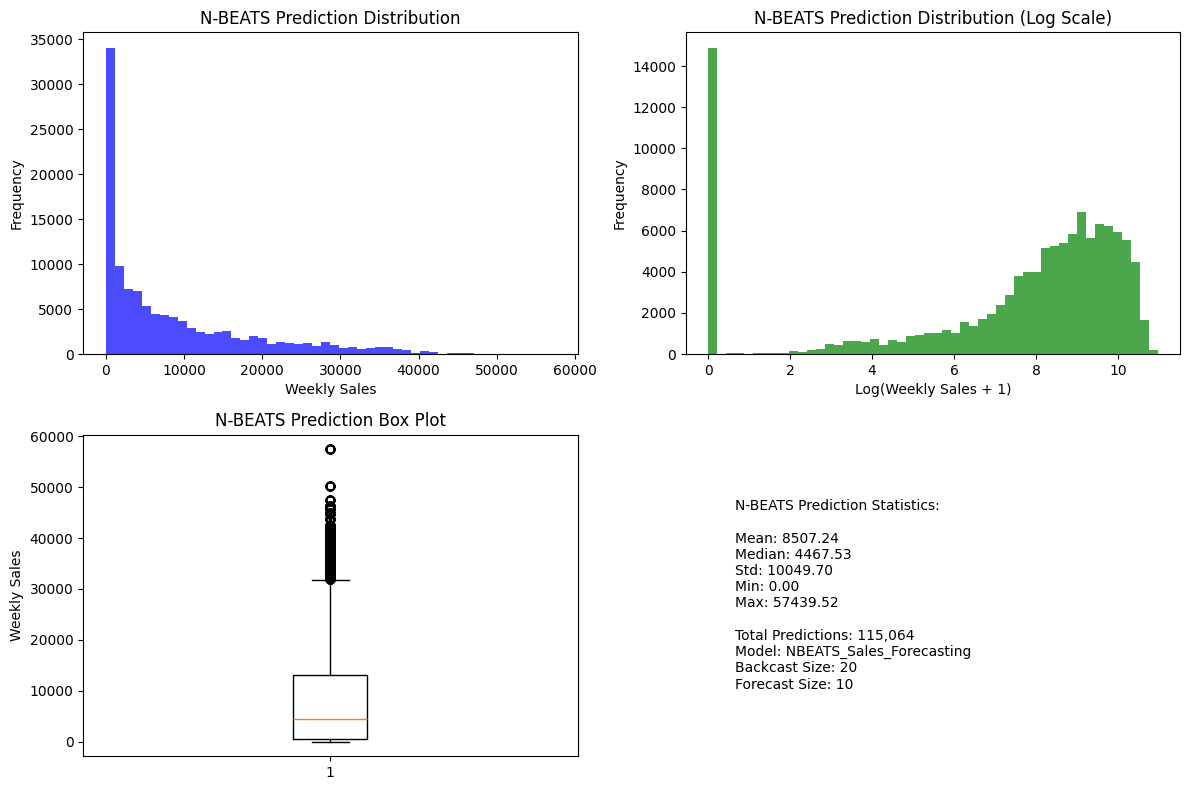

✅ Inference results logged to MLflow


In [14]:
if len(predictions) > 0:
    # Log inference results to MLflow
    with mlflow.start_run(run_name="NBEATS_Inference_Results"):
        # Log inference parameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("inference_date", pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S'))
        mlflow.log_param("backcast_size", BACKCAST_SIZE)
        mlflow.log_param("forecast_size", FORECAST_SIZE)
        mlflow.log_param("n_features", len(best_features))
        mlflow.log_param("total_predictions", len(predictions))

        # Log prediction statistics
        mlflow.log_metric("mean_prediction", submission_df['Weekly_Sales'].mean())
        mlflow.log_metric("median_prediction", submission_df['Weekly_Sales'].median())
        mlflow.log_metric("std_prediction", submission_df['Weekly_Sales'].std())
        mlflow.log_metric("min_prediction", submission_df['Weekly_Sales'].min())
        mlflow.log_metric("max_prediction", submission_df['Weekly_Sales'].max())

        # Log submission file
        mlflow.log_artifact('nbeats_submission.csv')

        # Create and log prediction distribution plot
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 8))

        # Prediction distribution
        plt.subplot(2, 2, 1)
        plt.hist(submission_df['Weekly_Sales'], bins=50, alpha=0.7, color='blue')
        plt.title('N-BEATS Prediction Distribution')
        plt.xlabel('Weekly Sales')
        plt.ylabel('Frequency')

        # Log-scale distribution (to see details better)
        plt.subplot(2, 2, 2)
        plt.hist(np.log1p(submission_df['Weekly_Sales']), bins=50, alpha=0.7, color='green')
        plt.title('N-BEATS Prediction Distribution (Log Scale)')
        plt.xlabel('Log(Weekly Sales + 1)')
        plt.ylabel('Frequency')

        # Box plot
        plt.subplot(2, 2, 3)
        plt.boxplot(submission_df['Weekly_Sales'])
        plt.title('N-BEATS Prediction Box Plot')
        plt.ylabel('Weekly Sales')

        # Summary statistics
        plt.subplot(2, 2, 4)
        stats_text = f"""N-BEATS Prediction Statistics:

Mean: {submission_df['Weekly_Sales'].mean():.2f}
Median: {submission_df['Weekly_Sales'].median():.2f}
Std: {submission_df['Weekly_Sales'].std():.2f}
Min: {submission_df['Weekly_Sales'].min():.2f}
Max: {submission_df['Weekly_Sales'].max():.2f}

Total Predictions: {len(submission_df):,}
Model: {model_name}
Backcast Size: {BACKCAST_SIZE}
Forecast Size: {FORECAST_SIZE}"""

        plt.text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('nbeats_prediction_analysis.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('nbeats_prediction_analysis.png')
        plt.show()

        print("✅ Inference results logged to MLflow")

In [15]:
print("\n" + "="*80)
print("N-BEATS INFERENCE COMPLETED SUCCESSFULLY!")
print("="*80)

if len(predictions) > 0:
    print(f"📊 PREDICTIONS GENERATED: {len(predictions):,}")
    print(f"📈 MEAN PREDICTION: {submission_df['Weekly_Sales'].mean():.2f}")
    print(f"📊 MEDIAN PREDICTION: {submission_df['Weekly_Sales'].median():.2f}")
    print(f"📋 SUBMISSION FILE: 'nbeats_submission.csv'")

    print(f"\n🔬 MODEL DETAILS:")
    print(f"   Model: {model_name}")
    print(f"   Features: {len(best_features)} features")
    print(f"   Backcast Size: {BACKCAST_SIZE} weeks")
    print(f"   Forecast Size: {FORECAST_SIZE} weeks")

    print(f"\n📈 READY FOR KAGGLE SUBMISSION!")
    print(f"   1. Download 'nbeats_submission.csv'")
    print(f"   2. Upload to Kaggle competition")
    print(f"   3. Compare with Prophet baseline results")

    print(f"\n🎯 ANALYSIS INSIGHTS:")
    print(f"   • N-BEATS uses deep learning for time series forecasting")
    print(f"   • Model captures trend and seasonality patterns")
    print(f"   • Compare performance with Prophet's statistical approach")
    print(f"   • Use results for architecture comparison in your report")

else:
    print("❌ NO PREDICTIONS GENERATED")
    print("   Please check:")
    print("   - Model loading was successful")
    print("   - Data preprocessing completed")
    print("   - Store-department combinations have sufficient history")

print("="*80)
print("🚀 N-BEATS INFERENCE PIPELINE COMPLETE!")
print("="*80)


N-BEATS INFERENCE COMPLETED SUCCESSFULLY!
📊 PREDICTIONS GENERATED: 115,064
📈 MEAN PREDICTION: 8507.24
📊 MEDIAN PREDICTION: 4467.53
📋 SUBMISSION FILE: 'nbeats_submission.csv'

🔬 MODEL DETAILS:
   Model: NBEATS_Sales_Forecasting
   Features: 13 features
   Backcast Size: 20 weeks
   Forecast Size: 10 weeks

📈 READY FOR KAGGLE SUBMISSION!
   1. Download 'nbeats_submission.csv'
   2. Upload to Kaggle competition
   3. Compare with Prophet baseline results

🎯 ANALYSIS INSIGHTS:
   • N-BEATS uses deep learning for time series forecasting
   • Model captures trend and seasonality patterns
   • Compare performance with Prophet's statistical approach
   • Use results for architecture comparison in your report
🚀 N-BEATS INFERENCE PIPELINE COMPLETE!
